# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
#Reproducibility
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
#Load data
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print("\nColumn types:")
display(df.dtypes.value_counts())


Column types:


,count
object,18
int64,2
float64,1


In [6]:
print("\nChurn distribution (counts):")
display(df['Churn'].value_counts())


Churn distribution (counts):


,count
Churn,
No,5174
Yes,1869


In [7]:
print("\nChurn distribution (proportions):")
display(df['Churn'].value_counts(normalize=True))


Churn distribution (proportions):


,proportion
Churn,
No,0.73463
Yes,0.26537


In [8]:
#Data cleaning
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Inspect rows with missing TotalCharges
missing_tc = df[df['TotalCharges'].isna()]
print("Rows with missing TotalCharges:", missing_tc.shape[0])
if not missing_tc.empty:
    display(missing_tc.head())

#Drop rows with missing TotalCharges
df = df[df['TotalCharges'].notna()].copy()
df.reset_index(drop=True, inplace=True)

Rows with missing TotalCharges: 11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No


In [9]:
# Drop identifier
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Map target to numeric
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

print("After cleaning shape:", df.shape)


After cleaning shape: (7032, 20)


/tmp/ipython-input-3787337931.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='viridis')


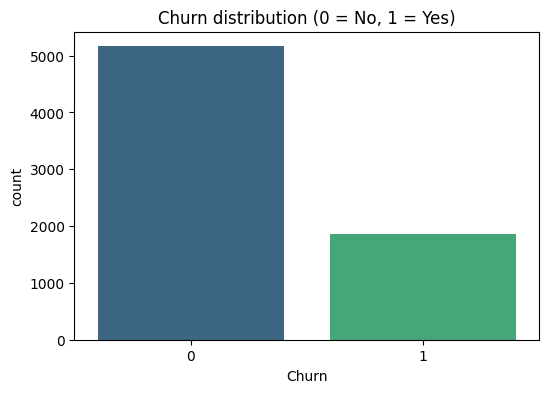

In [10]:
#Visualizations
#Churn countplot
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='viridis')
plt.title('Churn distribution (0 = No, 1 = Yes)')
plt.show()

/tmp/ipython-input-2458575327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')
/tmp/ipython-input-2458575327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')
/tmp/ipython-input-2458575327.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')


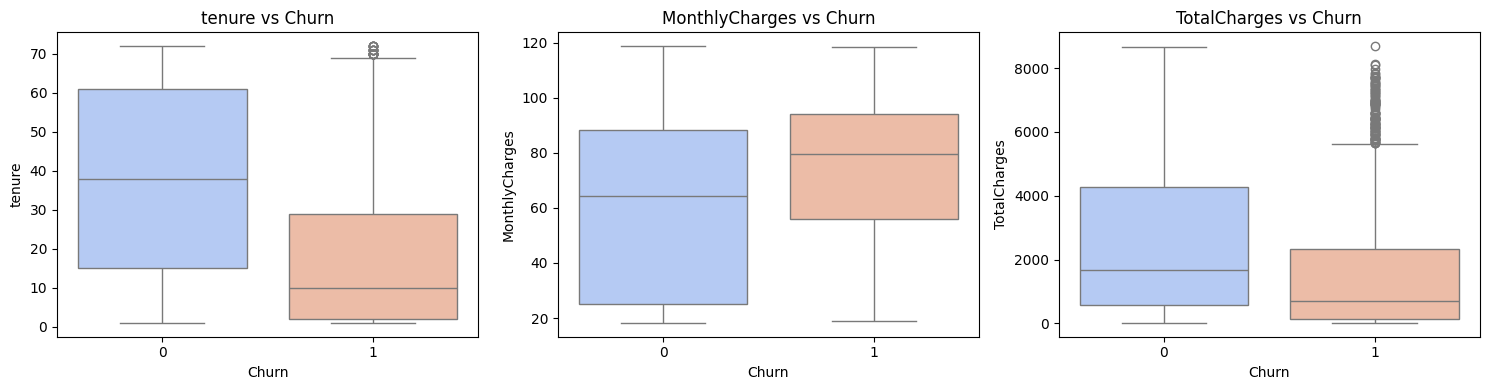

In [11]:
#Boxplots for numeric features vs churn
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, len(num_cols), figsize=(5*len(num_cols), 4))
for ax, col in zip(axes, num_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=ax, palette='coolwarm')
    ax.set_title(f'{col} vs Churn')
plt.tight_layout()
plt.show()

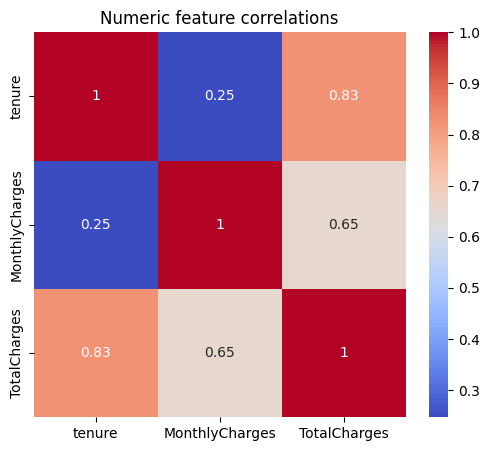

In [12]:
#Correlation heatmap for numeric features
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Numeric feature correlations')
plt.show()

In [14]:
#Data Preprocessing

# Identify numeric and categorical columns
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [c for c in df.columns if c not in numeric_features + ['Churn']]

print("Numeric features:", numeric_features)
print("Categorical features (sample):", categorical_features[:10])

# ColumnTransformer: scale numeric, one-hot encode categorical (ignore unknown categories)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'  # drop any other columns
)

# Prepare X and y
X = df.drop('Churn', axis=1)
y = df['Churn']

# Fit-transform on training split only (we will do split next)

Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features (sample): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']


In [16]:
# 06 - Train-test split and preprocessing fit

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed, stratify=y
)

# Fit preprocessor on training data and transform both train and test
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

print("Preprocessed shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)

Preprocessed shapes -> X_train: (5625, 46) X_test: (1407, 46)


In [17]:
#Class weights for imbalance handling
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.6809927360774818), 1: np.float64(1.8812709030100334)}


In [20]:
#Decision Tree pipeline + GridSearchCV

# Build a pipeline: preprocessor already applied, but we can include it for safety in GridSearch
dt_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=random_seed, class_weight='balanced'))
])

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 5, 8, 12],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
grid = GridSearchCV(dt_pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train_raw, y_train)  # pipeline will fit preprocessor internally

best_dt_pipeline = grid.best_estimator_
print("Best DT params:", grid.best_params_)

# Evaluate on test set
y_pred_dt = best_dt_pipeline.predict(X_test_raw)
y_proba_dt = best_dt_pipeline.predict_proba(X_test_raw)[:, 1]

print("\nDecision Tree (tuned) classification report:")
print(classification_report(y_test, y_pred_dt, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba_dt))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best DT params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}

Decision Tree (tuned) classification report:
              precision    recall  f1-score   support

           0     0.8907    0.7570    0.8184      1033
           1     0.5255    0.7433    0.6157       374

    accuracy                         0.7534      1407
   macro avg     0.7081    0.7502    0.7171      1407
weighted avg     0.7936    0.7534    0.7645      1407

ROC AUC: 0.829046544253537


In [21]:
#Neural Network (Keras) training

# Prepare arrays for Keras (preprocessor already fit)
X_train_nn = X_train  # from earlier preprocessor.fit_transform
X_test_nn = X_test

input_dim = X_train_nn.shape[1]

def build_nn(input_dim, lr=1e-3, dropout_rates=(0.3, 0.2)):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rates[0]),
        Dense(64, activation='relu'),
        Dropout(dropout_rates[1]),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

nn_model = build_nn(input_dim, lr=1e-3)
nn_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    # ModelCheckpoint omitted per your request (no artifacts saving)
]

history = nn_model.fit(
    X_train_nn, y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=2
)

# Predictions
y_proba_nn = nn_model.predict(X_test_nn).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,385 (64.00 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
75/75 - 5s - 70ms/step - accuracy: 0.6819 - loss: 0.5719 - val_accuracy: 0.7453 - val_loss: 0.5433
Epoch 2/100
75/75 - 1s - 9ms/step - accuracy: 0.7559 - loss: 0.5052 - val_accuracy: 0.7453 - val_loss: 0.5243
Epoch 3/100
75/75 - 1s - 16ms/step - accuracy: 0.7547 - loss: 0.4987 - val_accuracy: 0.7382 - val_loss: 0.5236
Epoch 4/100
75/75 - 1s - 12ms/step - accuracy: 0.7538 - loss: 0.4936 - val_accuracy: 0.7417 - val_loss: 0.5167
Epoch 5/100
75/75 - 1s - 9ms/step - accuracy: 0.7534 - loss: 0.4913 - val_accuracy: 0.7429 - val_loss: 0.5166
Epoch 6/100
75/75 - 0s - 4ms/step - accuracy: 0.7578 - loss: 0.4897 - val_accuracy: 0.7417 - val_loss: 0.5250
Epoch 7/100
75/75 - 0s - 5ms/step - accuracy: 0.7630 - loss: 0.4814 - val_accuracy: 0.7382 - val_loss: 0.5264
Epoch 8/100
75/75 - 0s - 6ms/step - accuracy: 0.7574 - loss: 0.4784 - val_accuracy: 0.7405 - val_loss: 0.5279
Epoch 9/100
75/75 - 0s - 6ms/step - accuracy: 0.7553 - loss: 0.4809 - val_accuracy: 0.7441 - val_loss: 0.5202
Epoch 1

--- Decision Tree (tuned) ---
Accuracy: 0.7533759772565742
Precision: 0.5255198487712666
Recall: 0.7433155080213903
F1: 0.6157253599114064
ROC AUC: 0.829046544253537
PR AUC: 0.6083761291308546
              precision    recall  f1-score   support

           0     0.8907    0.7570    0.8184      1033
           1     0.5255    0.7433    0.6157       374

    accuracy                         0.7534      1407
   macro avg     0.7081    0.7502    0.7171      1407
weighted avg     0.7936    0.7534    0.7645      1407

--- Neural Network ---
Accuracy: 0.7135749822316987
Precision: 0.4777947932618683
Recall: 0.8342245989304813
F1: 0.6075949367088608
ROC AUC: 0.8360377592909909
PR AUC: 0.629755397522768
              precision    recall  f1-score   support

           0     0.9178    0.6699    0.7745      1033
           1     0.4778    0.8342    0.6076       374

    accuracy                         0.7136      1407
   macro avg     0.6978    0.7521    0.6910      1407
weighted avg     0.800

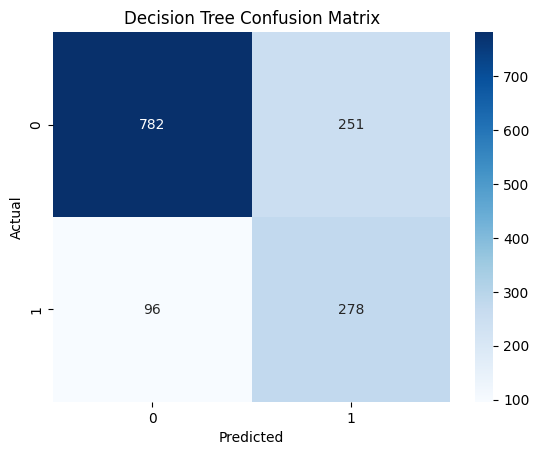

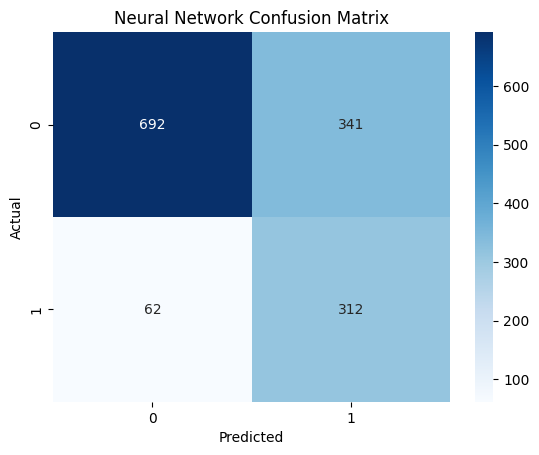

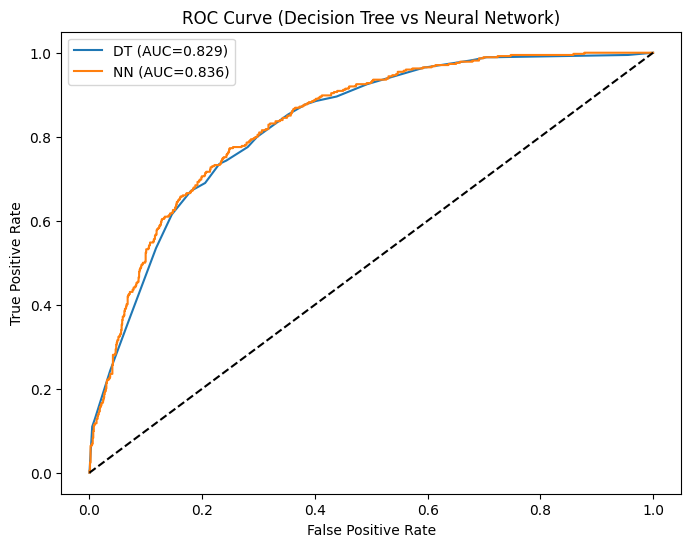

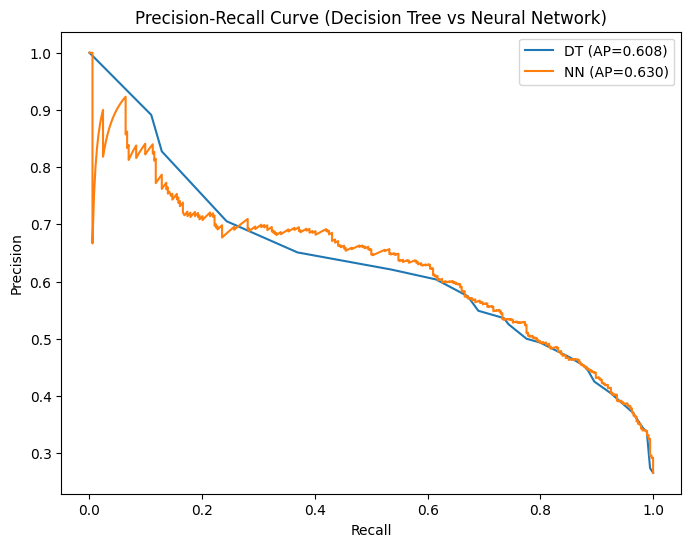

In [22]:
# 10 - Evaluation: metrics, confusion matrices, ROC & PR curves

def print_metrics(y_true, y_pred, y_proba=None, label='Model'):
    print(f"--- {label} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
        print("PR AUC:", average_precision_score(y_true, y_proba))
    print(classification_report(y_true, y_pred, digits=4))

# Decision Tree metrics
print_metrics(y_test, y_pred_dt, y_proba_dt, label='Decision Tree (tuned)')

# Neural Network metrics
print_metrics(y_test, y_pred_nn, y_proba_nn, label='Neural Network')

# Confusion matrices
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_dt, 'Decision Tree Confusion Matrix')
plot_confusion(y_test, y_pred_nn, 'Neural Network Confusion Matrix')

# ROC curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)

plt.figure(figsize=(8,6))
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={roc_auc_score(y_test, y_proba_dt):.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC={roc_auc_score(y_test, y_proba_nn):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree vs Neural Network)')
plt.legend()
plt.show()

# Precision-Recall curves
prec_dt, rec_dt, _ = precision_recall_curve(y_test, y_proba_dt)
prec_nn, rec_nn, _ = precision_recall_curve(y_test, y_proba_nn)
ap_dt = average_precision_score(y_test, y_proba_dt)
ap_nn = average_precision_score(y_test, y_proba_nn)

plt.figure(figsize=(8,6))
plt.plot(rec_dt, prec_dt, label=f'DT (AP={ap_dt:.3f})')
plt.plot(rec_nn, prec_nn, label=f'NN (AP={ap_nn:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Decision Tree vs Neural Network)')
plt.legend()
plt.show()

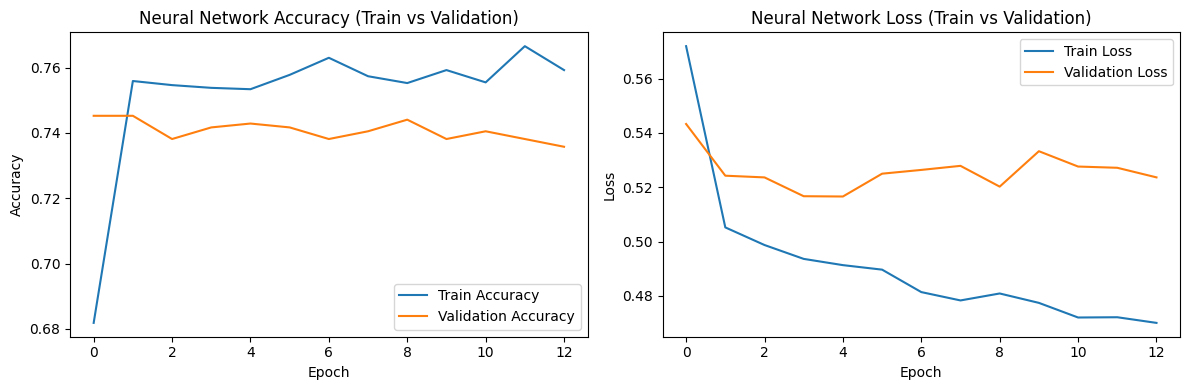

In [23]:
# 11 - Plot NN training history with clear titles

hist = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy (Train vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss (Train vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()